# Image classification from scratch

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from scipy.special import expit
from IPython.display import Image, display
import matplotlib as mpl

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Python/dataset.zip -d /content

Archive:  drive/MyDrive/Python/dataset.zip
   creating: /content/dataset/Bike/
  inflating: /content/dataset/Bike/Bike (1).jpeg  
  inflating: /content/dataset/Bike/Bike (1).jpg  
  inflating: /content/dataset/Bike/Bike (1).png  
  inflating: /content/dataset/Bike/Bike (10).jpeg  
  inflating: /content/dataset/Bike/Bike (10).jpg  
  inflating: /content/dataset/Bike/Bike (10).png  
  inflating: /content/dataset/Bike/Bike (100).jpeg  
  inflating: /content/dataset/Bike/Bike (100).jpg  
  inflating: /content/dataset/Bike/Bike (1000).jpeg  
  inflating: /content/dataset/Bike/Bike (1001).jpeg  
  inflating: /content/dataset/Bike/Bike (1002).jpeg  
  inflating: /content/dataset/Bike/Bike (1003).jpeg  
  inflating: /content/dataset/Bike/Bike (1004).jpeg  
  inflating: /content/dataset/Bike/Bike (1005).jpeg  
  inflating: /content/dataset/Bike/Bike (1006).jpeg  
  inflating: /content/dataset/Bike/Bike (1007).jpeg  
  inflating: /content/dataset/Bike/Bike (1008).jpeg  
  inflating: /content/dat

In [ ]:
def resize_img(dir):
  # Создаем выходную папку, если она не существует
  if not os.path.exists(dir):
      os.makedirs(dir)

  # Проходим по всем файлам в папке с изображениями
  for filename in os.listdir(dir):
      # Проверяем, что файл - изображение
      if filename.endswith(".jpg") or filename.endswith(".png"):
          # Открываем изображение с помощью OpenCV
          img = cv2.imread(os.path.join(dir, filename))
          # Изменяем размер изображения до 250x250
          resized_img = cv2.resize(img, (250, 250))
          # Сохраняем измененное изображение в выходную папку
          cv2.imwrite(os.path.join(dir, filename), resized_img)

  print("Изменение размера завершено!")

In [ ]:
resize_img("/content/dataset/Bike")
resize_img("/content/dataset/Car")

Изменение размера завершено!
Изменение размера завершено!


In [ ]:
image_size = (250, 250)
batch_size = 16

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,

    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


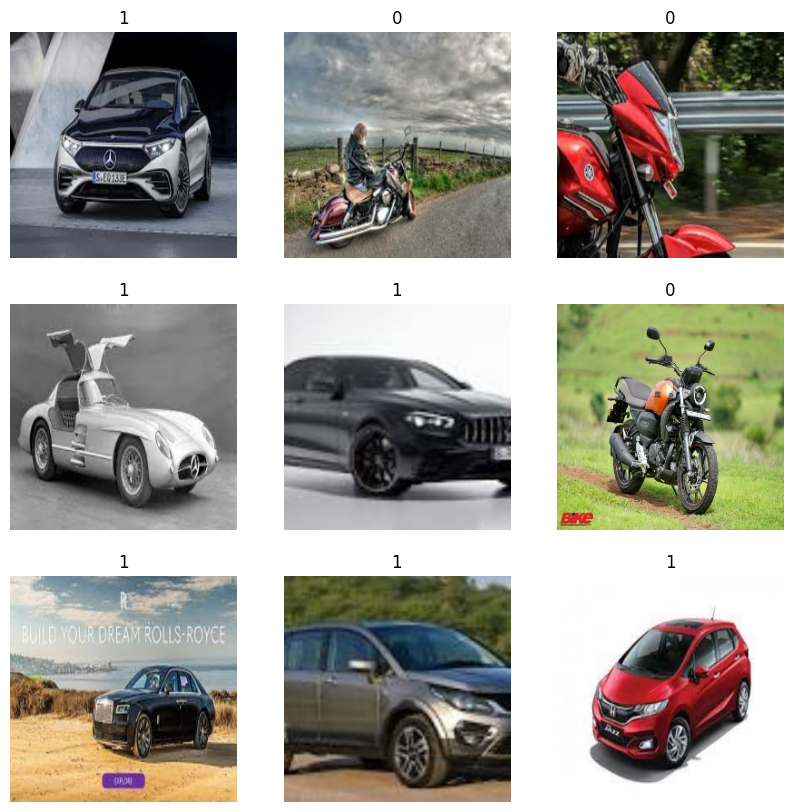

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

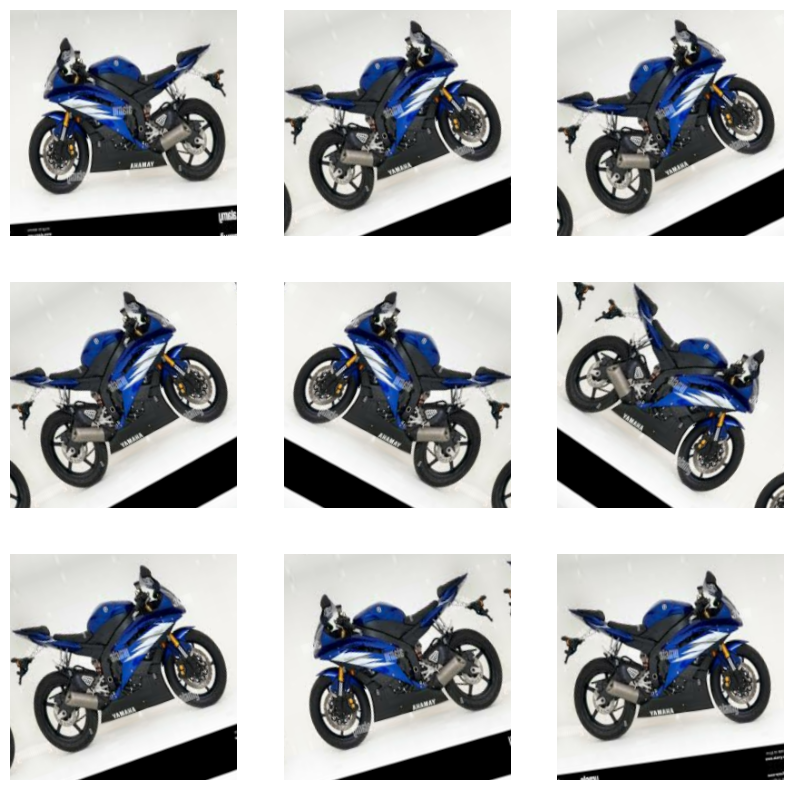

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(150, 150))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (tf.image.resize(x, image_size), y))
val_ds = val_ds.map(
    lambda x, y: (tf.image.resize(x, image_size), y))

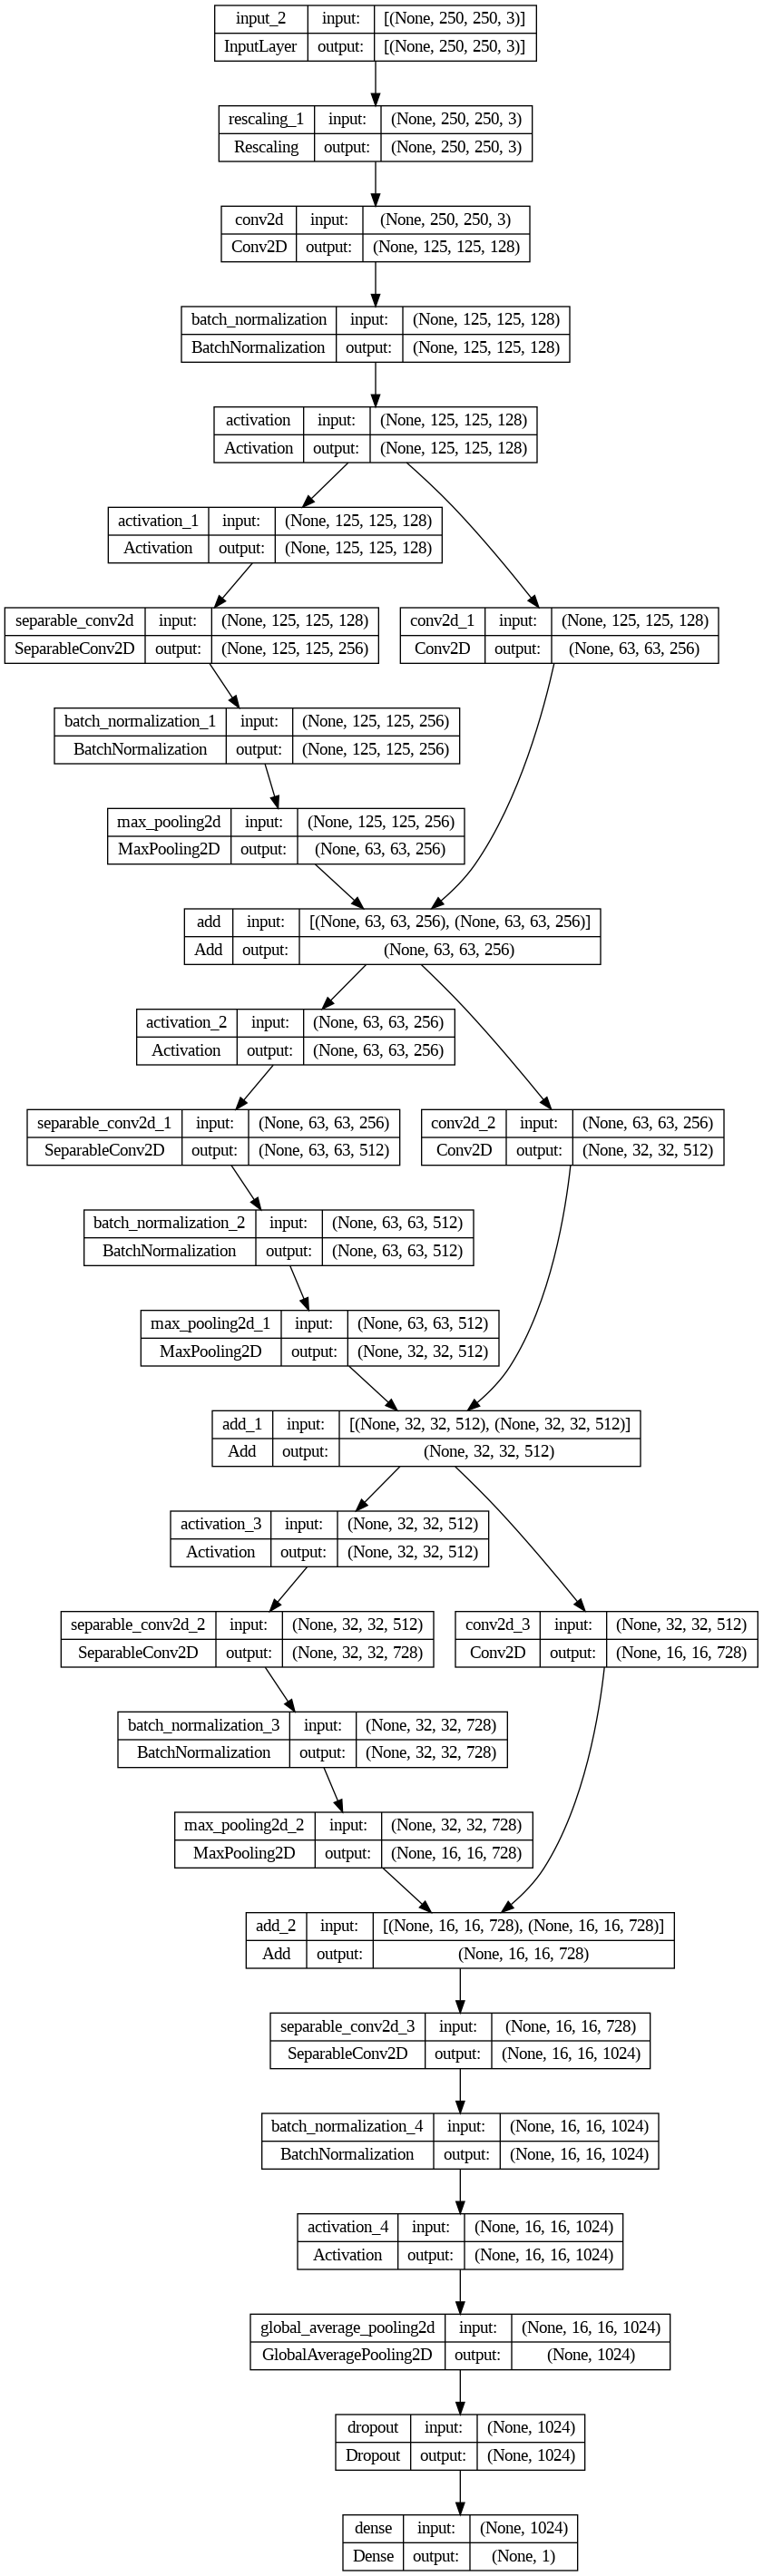

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
200/200 [==============================] - 53s 192ms/step - loss: 0.4899 - acc: 0.7559 - val_loss: 0.7369 - val_acc: 0.5025
Epoch 2/5
200/200 [==============================] - 40s 199ms/step - loss: 0.3469 - acc: 0.8534 - val_loss: 1.0564 - val_acc: 0.5025
Epoch 3/5
200/200 [==============================] - 36s 176ms/step - loss: 0.2975 - acc: 0.8747 - val_loss: 0.6544 - val_acc: 0.6388
Epoch 4/5
200/200 [==============================] - 38s 187ms/step - loss: 0.2558 - acc: 0.9069 - val_loss: 0.7765 - val_acc: 0.6762
Epoch 5/5
200/200 [==============================] - 36s 180ms/step - loss: 0.2206 - acc: 0.9134 - val_loss: 0.1665 - val_acc: 0.9400


In [ ]:
!unzip drive/MyDrive/Python/test_data.zip -d /content

Archive:  drive/MyDrive/Python/test_data.zip
  inflating: /content/test_data/bike1.jpg  
  inflating: /content/test_data/bike2.jpg  
  inflating: /content/test_data/bike3.jpg  
  inflating: /content/test_data/car1.jpg  
  inflating: /content/test_data/car2.jpg  
  inflating: /content/test_data/car3.jpg  


In [ ]:
def test(test_dir):
  car_count = 0
  bike_count = 0
  for filename in os.listdir(test_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(test_dir, filename)
        img = keras.utils.load_img(img_path, target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array)
        score = float(expit(predictions[0][0]))
        if score < 0.5:
            print(f"{filename} is a bike with a confidence of {100 * (1 - score):.2f}%")
            bike_count += 1
        else:
            print(f"{filename} is a car with a confidence of {100 * score:.2f}%")
            car_count += 1

        plt.imshow(img)
        if score < 0.5:
            plt.title(f"Bike - Confidence: {100 * (1 - score):.2f}%")
        else:
            plt.title(f"Car - Confidence: {100 * score:.2f}%")
        plt.axis("off")
        plt.show()

  return car_count, bike_count

In [ ]:
def test(test_dir):
  car_count = 0
  bike_count = 0
  for filename in os.listdir(test_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(test_dir, filename)
        img = keras.utils.load_img(img_path, target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array)
        score = float(expit(predictions[0][0]))
        if score < 0.5:
            print(f"{filename} is a bike with a confidence of {100 * (1 - score):.2f}%")
            bike_count += 1
        else:
            print(f"{filename} is a car with a confidence of {100 * score:.2f}%")
            car_count += 1

        plt.imshow(img)
        if score < 0.5:
            plt.title(f"Bike - Confidence: {100 * (1 - score):.2f}%")
        else:
            plt.title(f"Car - Confidence: {100 * score:.2f}%")
        plt.axis("off")
        plt.show()

  return car_count, bike_count

1/1 [==============================] - 0s 21ms/step
bike3.jpg is a bike with a confidence of 99.74%


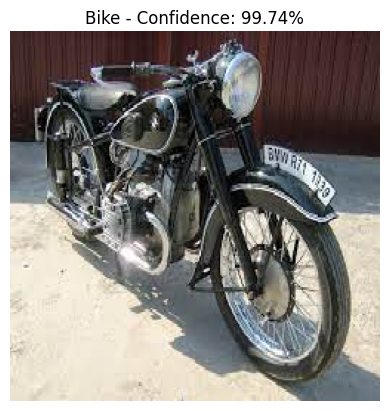

1/1 [==============================] - 0s 19ms/step
bike1.jpg is a bike with a confidence of 93.97%


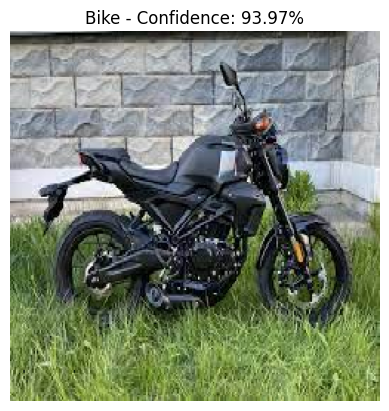

1/1 [==============================] - 0s 26ms/step
car2.jpg is a car with a confidence of 99.94%


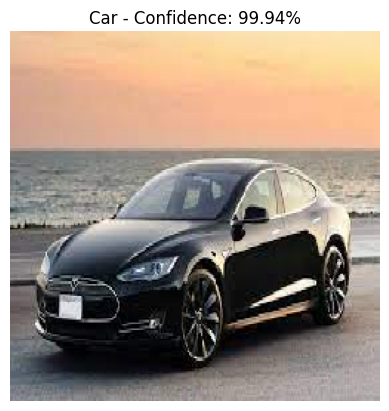

1/1 [==============================] - 0s 26ms/step
bike2.jpg is a bike with a confidence of 99.18%


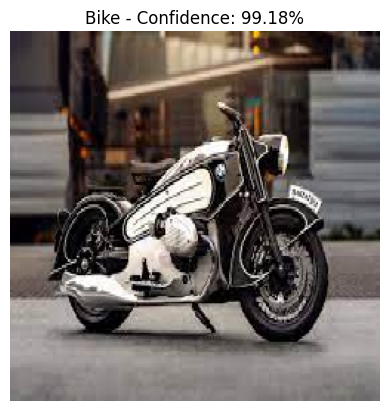

1/1 [==============================] - 0s 19ms/step
car1.jpg is a car with a confidence of 89.54%


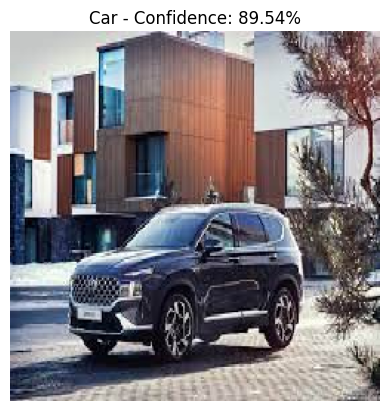

1/1 [==============================] - 0s 18ms/step
car3.jpg is a car with a confidence of 99.15%


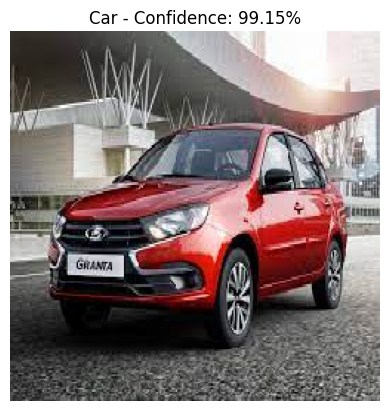

Total cars: 3
Total bikes: 3


In [ ]:
car_count, bike_count = test("test_data")

print(f"Total cars: {car_count}")
print(f"Total bikes: {bike_count}")

77520/77520 [==============================] - 0s 0us/step


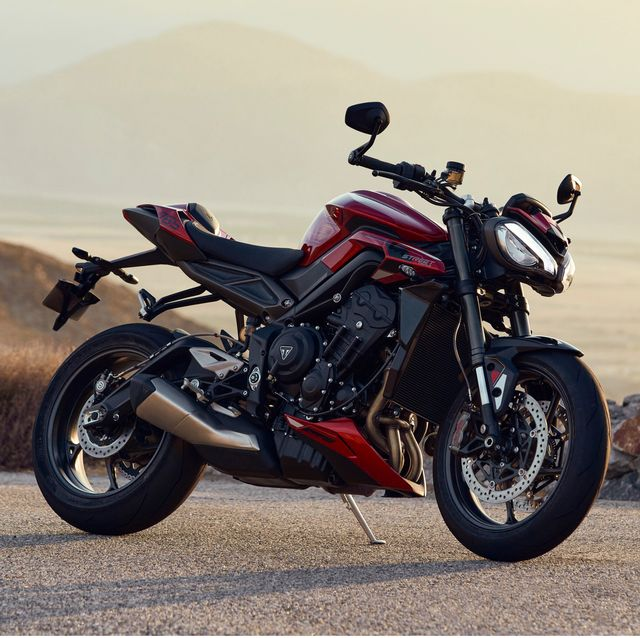

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "bike.jpg", "https://hips.hearstapps.com/hmg-prod/images/moto-1-1668468105.jpg?crop=0.458xw:0.962xh;0.0211xw,0.0205xh&resize=640:*"
)

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 841ms/step
Predicted: [('n03127747', 'crash_helmet', 7.815919)]


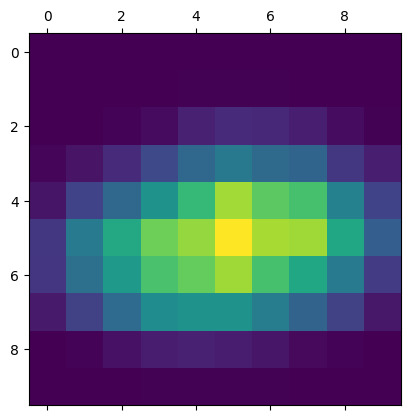

In [ ]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

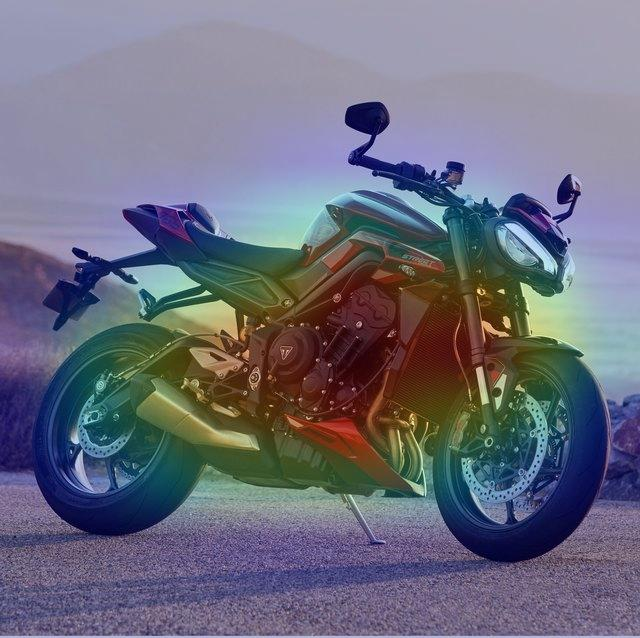

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

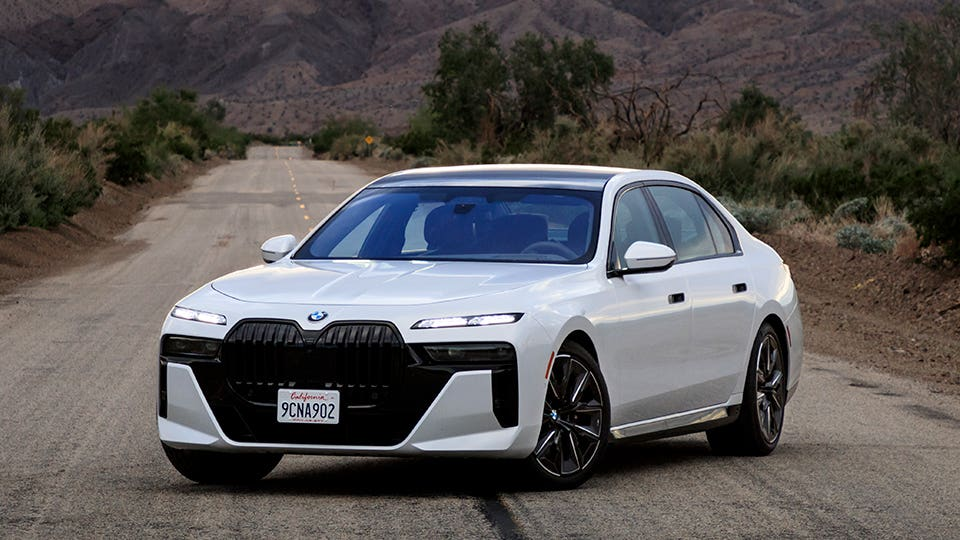

In [ ]:
img_path = keras.utils.get_file(
    "car.jpg",
    "https://thumbor.forbes.com/thumbor/fit-in/960x600/https://www.forbes.com/wheels/wp-content/uploads/2022/07/2023_BMW_7_Series_Gallery1.jpg",
)

display(Image(img_path))

1/1 [==============================] - 0s 24ms/step
Predicted: [('n04285008', 'sports_car', 8.551337)]


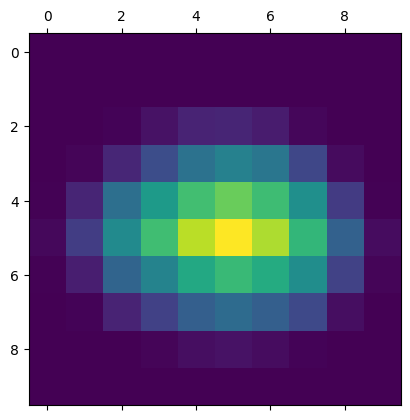

In [ ]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

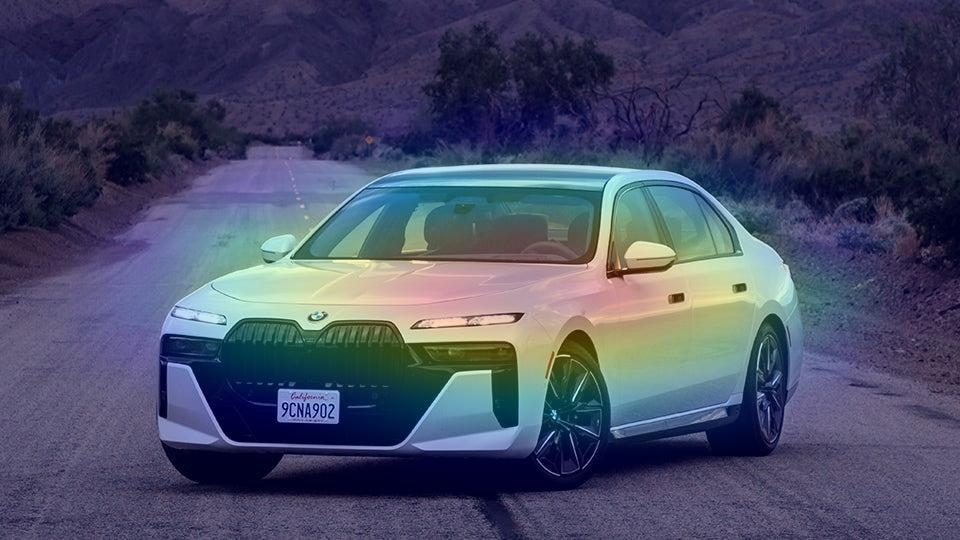

In [ ]:
save_and_display_gradcam(img_path, heatmap)